In [14]:
import numpy as np
from collections import Counter

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # check the stopping criteria
        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        # create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)


    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # calculate the information gain
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold


    def _information_gain(self, y, X_column, threshold):
        # parent entropy
        parent_entropy = self._entropy(y)

        # create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # calculate the weighted avg. entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r

        # calculate the IG
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p>0])


    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import  pandas as pd
dataset = pd.read_csv("bill_authentication.csv")
dataset.head()

,Variance,Skewness,Curtosis,Entropy,Class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [16]:
X = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1].values

In [17]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=0)

In [18]:
clf = DecisionTree(max_depth=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)

acc = accuracy(y_test, predictions)
print(acc)

0.9854545454545455


In [19]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy',random_state= 0)
classifier.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [20]:
from sklearn.metrics import confusion_matrix,accuracy_score
print(y_test.shape)
cm = confusion_matrix(y_test, y_pred)
print(cm)

accuracy = accuracy_score (y_test, y_pred)*100
print('Accuracy is ' + str(accuracy) + ' %.')

(275,)
[[154   3]
 [  1 117]]
Accuracy is 98.54545454545455 %.


In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       157
           1       0.97      0.99      0.98       118

    accuracy                           0.99       275
   macro avg       0.98      0.99      0.99       275
weighted avg       0.99      0.99      0.99       275



In [22]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
text_representation = tree.export_text(classifier)
print(text_representation)

|--- feature_0 <= 0.27
|   |--- feature_1 <= 5.87
|   |   |--- feature_2 <= 6.75
|   |   |   |--- feature_0 <= -0.26
|   |   |   |   |--- class: 1
|   |   |   |--- feature_0 >  -0.26
|   |   |   |   |--- feature_0 <= -0.25
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_0 >  -0.25
|   |   |   |   |   |--- class: 1
|   |   |--- feature_2 >  6.75
|   |   |   |--- feature_1 <= -4.80
|   |   |   |   |--- class: 1
|   |   |   |--- feature_1 >  -4.80
|   |   |   |   |--- class: 0
|   |--- feature_1 >  5.87
|   |   |--- feature_0 <= -3.44
|   |   |   |--- feature_3 <= -1.92
|   |   |   |   |--- class: 1
|   |   |   |--- feature_3 >  -1.92
|   |   |   |   |--- class: 0
|   |   |--- feature_0 >  -3.44
|   |   |   |--- class: 0
|--- feature_0 >  0.27
|   |--- feature_0 <= 2.39
|   |   |--- feature_2 <= -2.18
|   |   |   |--- feature_1 <= 6.42
|   |   |   |   |--- class: 1
|   |   |   |--- feature_1 >  6.42
|   |   |   |   |--- class: 0
|   |   |--- feature_2 >  -2.18
|   |   |   |

[Text(0.5208333333333334, 0.9375, 'x[0] <= 0.274\nentropy = 0.992\nsamples = 1097\nvalue = [605, 492]'),
 Text(0.3125, 0.8125, 'x[1] <= 5.865\nentropy = 0.679\nsamples = 524\nvalue = [94, 430]'),
 Text(0.16666666666666666, 0.6875, 'x[2] <= 6.746\nentropy = 0.278\nsamples = 416\nvalue = [20, 396]'),
 Text(0.08333333333333333, 0.5625, 'x[0] <= -0.257\nentropy = 0.032\nsamples = 304\nvalue = [1, 303]'),
 Text(0.041666666666666664, 0.4375, 'entropy = 0.0\nsamples = 266\nvalue = [0, 266]'),
 Text(0.125, 0.4375, 'x[0] <= -0.248\nentropy = 0.176\nsamples = 38\nvalue = [1, 37]'),
 Text(0.08333333333333333, 0.3125, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.16666666666666666, 0.3125, 'entropy = 0.0\nsamples = 37\nvalue = [0, 37]'),
 Text(0.25, 0.5625, 'x[1] <= -4.8\nentropy = 0.657\nsamples = 112\nvalue = [19, 93]'),
 Text(0.20833333333333334, 0.4375, 'entropy = 0.0\nsamples = 93\nvalue = [0, 93]'),
 Text(0.2916666666666667, 0.4375, 'entropy = 0.0\nsamples = 19\nvalue = [19, 0]'),
 

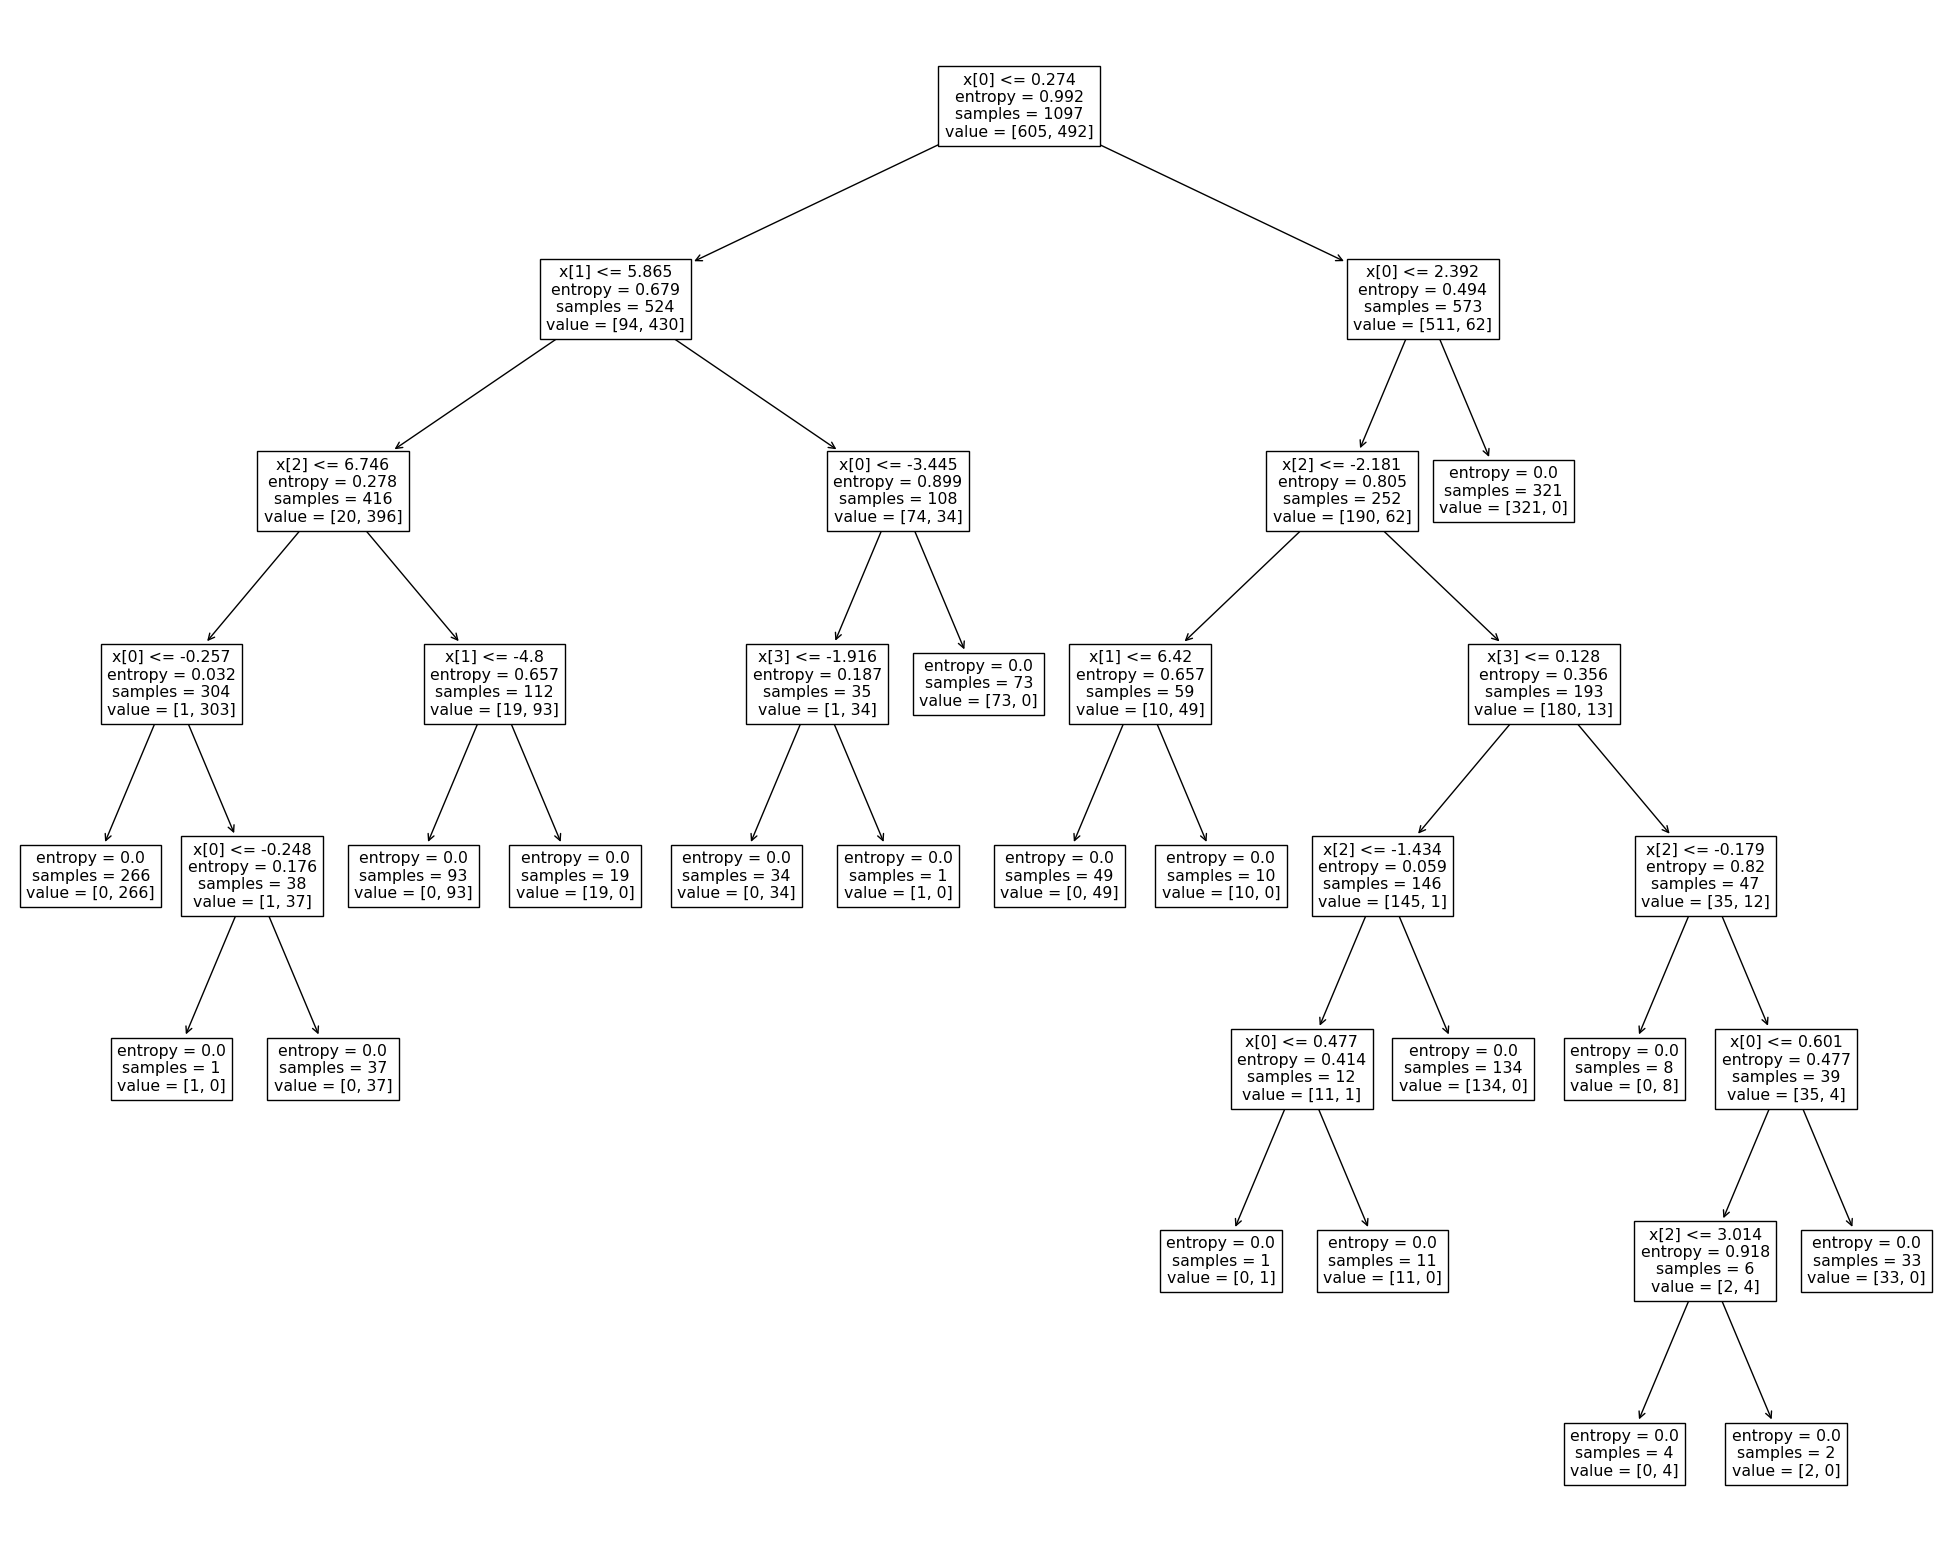

In [23]:
fig = plt.figure(figsize=(25,20))
tree.plot_tree(classifier)